In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import cv2
AUTOTUNE = tf.data.AUTOTUNE
from pathlib import Path
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
import sys

In [2]:
# learning_rate = 1e-4 #0.001
weight_decay = 0.0001
batch_size = 64
num_epochs = 50
image_size =  224
patch_size = 14  

num_patches = (image_size // patch_size) ** 2

projection_dim = 64 #64 #128 #64
num_heads = 6 #6 #4


transformer_units = [
    projection_dim * 2,
    projection_dim,
]  

transformer_layers = 8 #8 #3 #8

mlp_head_units = [256] #[512, 1024]

input_shape = [image_size, image_size, 3]
num_classes = 1

In [3]:
path = Path('../input/kwkbwk')
data_dir = path / 'chest_xray'

train_dir = data_dir / 'train'
test_dir = data_dir / 'test'
val_dir = data_dir / 'val'

files = (tf.io.gfile.glob(str(train_dir) + '/*/*'))
files.extend(tf.io.gfile.glob(str(val_dir) + '/*/*'))

test_data = (tf.io.gfile.glob(str(test_dir) + '/*/*'))

class_names = np.unique(sorted([item.name for item in data_dir.glob('*/*/')]))
print(class_names)

train_data, val_data = train_test_split(files, test_size=0.20)

['NORMAL' 'PNEUMONIA']


In [4]:
normal = (tf.io.gfile.glob(str(train_dir) + '/NORMAL/*'))
normal.extend(tf.io.gfile.glob(str(val_dir) + '/NORMAL/*'))
normal.extend(tf.io.gfile.glob(str(test_dir) + '/NORMAL/*'))

pneumonic = (tf.io.gfile.glob(str(train_dir) + '/PNEUMONIA/*'))
pneumonic.extend(tf.io.gfile.glob(str(test_dir) + '/PNEUMONIA/*'))
pneumonic.extend(tf.io.gfile.glob(str(val_dir) + '/PNEUMONIA/*'))

normal_image_count = len(normal)
pneumonic_image_count = len(pneumonic)
total = normal_image_count + pneumonic_image_count
print(f"normal images : {normal_image_count}")
print(f"pneumonic images : {pneumonic_image_count}")

normal images : 1583
pneumonic images : 4273


In [5]:
train_ds = tf.data.Dataset.from_tensor_slices(train_data)
val_ds = tf.data.Dataset.from_tensor_slices(val_data)
test_ds = tf.data.Dataset.from_tensor_slices(test_data)

2022-03-28 16:50:36.958498: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-28 16:50:37.046501: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-28 16:50:37.047180: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-28 16:50:37.049612: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [6]:
train_image_count = tf.data.experimental.cardinality(train_ds)
val_image_count = tf.data.experimental.cardinality(val_ds)
test_image_count = tf.data.experimental.cardinality(test_ds)

print(f"size of train dataset : {train_image_count}")
print(f"size of val dataset : {val_image_count}")
print(f"size of test dataset : {test_image_count}")

size of train dataset : 4185
size of val dataset : 1047
size of test dataset : 624


In [7]:
normal_train = (tf.io.gfile.glob(str(train_dir) + '/NORMAL/*'))
pneumonic_train = (tf.io.gfile.glob(str(train_dir) + '/PNEUMONIA/*'))

normal_train_count = len(normal_train)
pneumonic_train_count = len(pneumonic_train)

print(f"normal images : {normal_train_count}")
print(f"pneumonic images : {pneumonic_train_count}")

normal images : 1341
pneumonic images : 3875


In [8]:
weight_for_normal = (1 / normal_train_count) * (total / 2.0)
weight_for_pneumonic = (1 / pneumonic_train_count) * (total / 2.0)

class_weights = {0: weight_for_normal, 1: weight_for_pneumonic}

print('Weight for class 0: {:.2f}'.format(weight_for_normal))
print('Weight for class 1: {:.2f}'.format(weight_for_pneumonic))

Weight for class 0: 2.18
Weight for class 1: 0.76


In [9]:
def preprocess(file_path = data_dir):

    label = tf.strings.split(file_path, sep = '/')[-2]
    oneHot = label == class_names
    class_label = tf.argmax(oneHot)
    
    img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, (image_size, image_size))
    
    return img, class_label

train_ds = (tf.data.Dataset.from_tensor_slices(train_data)
    .map(preprocess, num_parallel_calls = AUTOTUNE)
    .shuffle(buffer_size = 1000)
    .batch(batch_size)
    .prefetch(buffer_size = AUTOTUNE))
val_ds = (tf.data.Dataset.from_tensor_slices(val_data)
    .map(preprocess, num_parallel_calls = AUTOTUNE)
    .shuffle(buffer_size = 1000)
    .batch(batch_size)
    .prefetch(buffer_size = AUTOTUNE))
test_ds = (tf.data.Dataset.from_tensor_slices(test_data)
    .map(preprocess, num_parallel_calls = AUTOTUNE)
#     .shuffle(buffer_size = 1000)
    .batch(batch_size)
    .prefetch(buffer_size = AUTOTUNE))


Normal Images--------


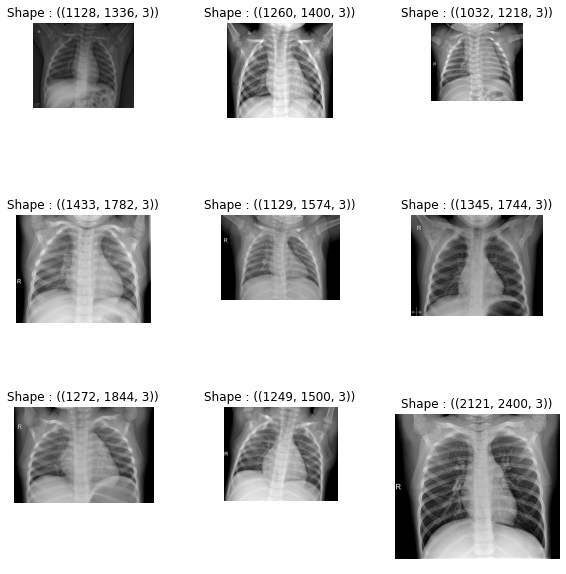

In [10]:
print("Normal Images--------")
fig, ax = plt.subplots(3, 3 , figsize = (10, 10), sharey =True)
for i in range(9):
    img = cv2.imread(normal[i])
    ax[i//3, i%3].imshow(img)
    ax[i//3, i%3].set_title(f"Shape : ({img.shape})")
    ax[i//3, i%3].axis('off')

Pneumonic Images--------


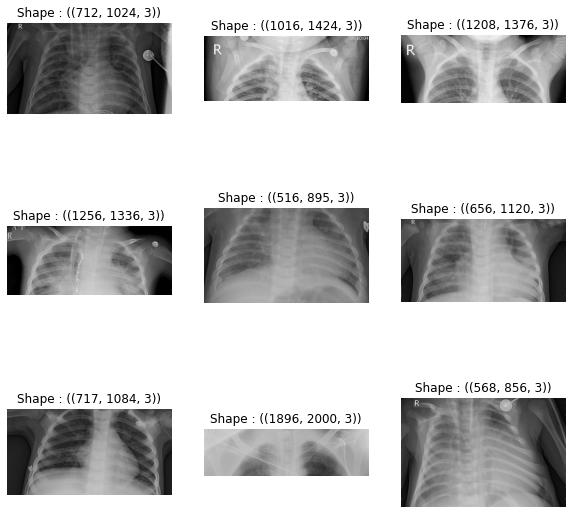

In [11]:
print("Pneumonic Images--------")
fig, ax = plt.subplots(3, 3 , figsize = (10, 10), sharey =True)
for i in range(9):
    img = cv2.imread(pneumonic[i])
    ax[i//3, i%3].imshow(img)
    ax[i//3, i%3].set_title(f"Shape : ({img.shape})")
    ax[i//3, i%3].axis('off')

2022-03-28 16:50:46.150611: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-28 16:50:56.155903: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 998 of 1000
2022-03-28 16:50:56.155964: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


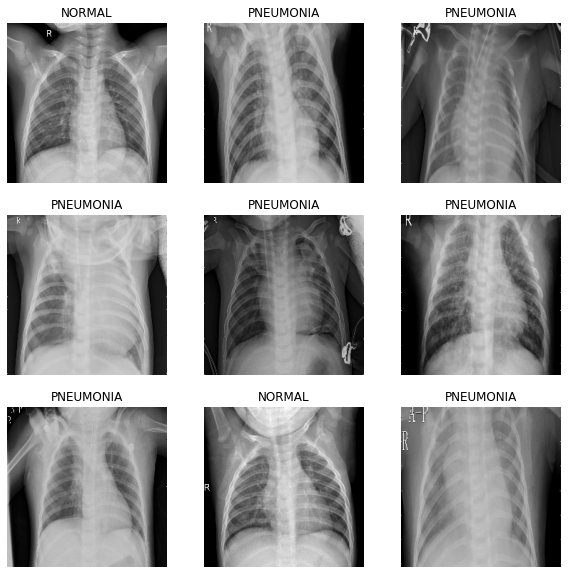

In [12]:
def show_img(images, labels):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis("off")

img,lbl = next(iter(train_ds))
show_img(img, lbl)

In [13]:
data_augmentation = keras.Sequential(
    [
#         layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
)

In [14]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        
    def call(self, images):
#         print(images.shape)
        batch_size = tf.shape(images)[0]
#         print(f"batch size: {batch_size}")
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
#         print(f"patches: {patches.shape}")
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
#         print(f"patches: {patches.shape}")
        return patches

PNEUMONIA


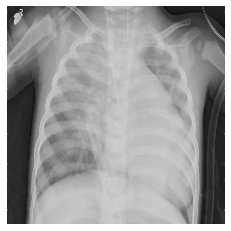

In [15]:
img,lbl = next(iter(train_ds))
# print(f"img shape: {img.shape}")
# print(f"lbl shape: {lbl.shape}")
x = (img[0].numpy().astype('uint8'))
plt.imshow(x, cmap="gray")
print(class_names[lbl[0]])
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([x]), size=(image_size, image_size)
)
# print(resized_image.shape)

Image size: 224 X 224
Patch size: 14 X 14
Patches per image: 256
Elements per patch: 588


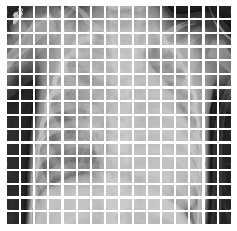

In [16]:
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
# print(n)

# b = patch[0].numpy().astype("uint8")
# print(f"b shape: {b.shape}")

plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [17]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [18]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
#         x = layers.Dense(units, activation=tf.nn.gelu)(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Dropout(dropout_rate)(x)
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout_rate)(x)
#         
       
#         x = layers.Dropout(dropout_rate)(x)
#         x = layers.BatchNormalization()(x)
    return x

In [19]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    
    augmented = data_augmentation(inputs)
    
    patches = Patches(patch_size)(augmented)
    
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes, activation = 'sigmoid')(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [20]:
METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name = 'auc'),
]

In [21]:
vit_classifier1 = create_vit_classifier()

In [23]:
# initial_learning_rate = 0.010
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
# )
# optimizer = tfa.optimizers.AdamW(
#     learning_rate=lr_schedule, weight_decay=weight_decay
# )
# Learning rate :

lr_schedule = tfa.optimizers.ExponentialCyclicalLearningRate(
            initial_learning_rate=1e-4,
            maximal_learning_rate=1e-2,
            step_size=2000,
            scale_mode="cycle",
            gamma=0.96,
            name="MyCyclicScheduler")

optimizer = tfa.optimizers.NovoGrad(learning_rate=lr_schedule)

#wrap OPTIMIZER WITH LookAhead layer
# optimizer = tfa.optimizers.Lookahead(optimizer) 

##Early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',restore_best_weights=True, patience = 10)

vit_classifier1.compile(
    optimizer=optimizer,
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=METRICS
    )

history1 = vit_classifier1.fit(
    train_ds,
    validation_data = val_ds,
    batch_size=batch_size,
    epochs=50,
    callbacks=[es],
    class_weight = class_weights,
)

Epoch 1/50
66/66 [==============================] - ETA: 0s - loss: 1.1417 - accuracy: 0.5295 - precision: 0.7644 - recall: 0.5301 - auc: 0.5342

2022-03-28 16:54:17.850529: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 904 of 1000
2022-03-28 16:54:18.918455: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


66/66 [==============================] - 114s 863ms/step - loss: 1.1417 - accuracy: 0.5295 - precision: 0.7644 - recall: 0.5301 - auc: 0.5342 - val_loss: 0.6371 - val_accuracy: 0.7039 - val_precision: 0.7990 - val_recall: 0.8010 - val_auc: 0.6562
Epoch 2/50
66/66 [==============================] - 41s 539ms/step - loss: 1.1471 - accuracy: 0.5130 - precision: 0.7485 - recall: 0.5188 - auc: 0.5119 - val_loss: 0.5946 - val_accuracy: 0.6934 - val_precision: 0.7323 - val_recall: 0.9225 - val_auc: 0.6425
Epoch 3/50
66/66 [==============================] - 40s 533ms/step - loss: 1.0554 - accuracy: 0.5462 - precision: 0.7760 - recall: 0.5471 - auc: 0.5499 - val_loss: 0.5463 - val_accuracy: 0.7106 - val_precision: 0.7367 - val_recall: 0.9470 - val_auc: 0.7206
Epoch 4/50
66/66 [==============================] - 41s 532ms/step - loss: 0.9892 - accuracy: 0.5436 - precision: 0.7746 - recall: 0.5439 - auc: 0.5635 - val_loss: 0.5036 - val_accuracy: 0.7354 - val_precision: 0.7777 - val_recall: 0.8992 

In [24]:
vit_classifier1.evaluate(test_ds)
# print(f"Test accuracy: {round(accuracy * 100, 2)}%")
# print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

10/10 [==============================] - 5s 482ms/step - loss: 0.3317 - accuracy: 0.8718 - precision: 0.8726 - recall: 0.9308 - auc: 0.9424


[0.33168211579322815,
 0.8717948794364929,
 0.8725961446762085,
 0.9307692050933838,
 0.942433774471283]